## DistillBert Model

In [43]:
results = []

In [1]:
!pip install pandas scikit-learn torch transformers

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [32]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report
import numpy as np
import time

In [3]:
# prepare
import pandas as pd
import ast

df = pd.read_csv(r"E:\Sem 7 Project\Datasets\Preprocessed Datasets\output_part_1.csv")
df['question_text'] = df['question_text'].apply(ast.literal_eval).apply(lambda x: ' '.join(x))
df['topic'] = df['topic'].apply(ast.literal_eval).apply(lambda x: x[0] if len(x) > 0 else '')
print(df[['question_text', 'topic']].head())

                                       question_text      topic
0  organ choos concern eye stage three point desp...    quantum
1  certainli turn marriag consid environ school p...     climat
2                       marriag best film dream wish  psycholog
3  guess soon hair compani letter fund mission me...    histori
4  know say congress view wear amount money succe...     machin


In [5]:
# encode labels
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['label'] = le.fit_transform(df['topic'])
num_labels = len(le.classes_)
print(df[['topic', 'label']].drop_duplicates().sort_values('label'))

               topic  label
6           artifici      0
28        blockchain      1
10            career      2
1             climat      3
5         cybersecur      4
39              data      5
17             digit      6
9               educ      7
22  entrepreneurship      8
7        environment      9
69            health     10
3            histori     11
4             machin     12
31            person     13
2          psycholog     14
0            quantum     15
20             robot     16
18          sociolog     17
8              space     18
14               web     19


In [6]:
# train splits
from sklearn.model_selection import train_test_split

train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['question_text'], df['label'], test_size=0.2, random_state=42, stratify=df['label']
)
print(len(train_texts), len(val_texts))

160 40


In [7]:
# tokenize text
from transformers import DistilBertTokenizer

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

def tokenize(texts, max_length=64):
    return tokenizer(
        list(texts),
        padding='max_length',
        truncation=True,
        max_length=max_length,
        return_tensors='pt'
    )

train_encodings = tokenize(train_texts)
val_encodings = tokenize(val_texts)
print(train_encodings.keys())

KeysView({'input_ids': tensor([[  101, 17935,  3775,  ...,     0,     0,     0],
        [  101,  3813,  2529,  ...,     0,     0,     0],
        [  101,  2025,  2594,  ...,     0,     0,     0],
        ...,
        [  101,  2530,  3519,  ...,     0,     0,     0],
        [  101,  2345,  5770,  ...,     0,     0,     0],
        [  101,  3693,  3095,  ...,     0,     0,     0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])})


In [8]:
# datasets objects
import torch

class BertDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels.iloc[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = BertDataset(train_encodings, train_labels)
val_dataset = BertDataset(val_encodings, val_labels)
print(len(train_dataset), len(val_dataset))

160 40


In [40]:
# model train
from transformers import DistilBertForSequenceClassification, Trainer, TrainingArguments

# model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=num_labels)
model = DistilBertForSequenceClassification.from_pretrained('./results_distilbert/checkpoint-300')

training_args = TrainingArguments(
    output_dir='./results_distilbert_new',
    num_train_epochs=8,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    # evaluation_strategy='epoch',
    # save_strategy='epoch',
    logging_dir='./logs_distilbert',
    logging_steps=10,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)
trainer.train()

Step,Training Loss
10,0.497400
20,0.424700
30,0.355200
40,0.275000
50,0.182800
60,0.153700
70,0.116000
80,0.094700
90,0.070600
100,0.061000


TrainOutput(global_step=160, training_loss=0.15591462049633265, metrics={'train_runtime': 1116.3513, 'train_samples_per_second': 1.147, 'train_steps_per_second': 0.143, 'total_flos': 21201587404800.0, 'train_loss': 0.15591462049633265, 'epoch': 8.0})

In [41]:
# evaluate
print(trainer.evaluate())

C:\Users\Meet\AppData\Roaming\Python\Python313\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


{'eval_loss': 3.7056403160095215, 'eval_runtime': 6.851, 'eval_samples_per_second': 5.839, 'eval_steps_per_second': 0.73, 'epoch': 8.0}


In [43]:
# prediction
test_texts = ["marriag best film dream wish"]
# Tokenize input (make sure to use the same tokenizer and max_length as in training)
test_encodings = tokenizer(
    test_texts,
    padding='max_length',
    truncation=True,
    max_length=64,
    return_tensors='pt'
)

# Set model to evaluation mode
model.eval()
test_encodings = tokenize(test_texts)
with torch.no_grad():
    inputs = {k: v for k, v in test_encodings.items() if k != "token_type_ids"}
    outputs = model(**inputs)
    probs = torch.softmax(outputs.logits, dim=1)
    pred_label = probs.argmax(dim=1).item()
    pred_topic = le.inverse_transform([pred_label])[0]
    print("Predicted topic:", pred_topic)

Predicted topic: robot


In [33]:
# Tokenize all validation texts
val_encodings = tokenizer(
    list(val_texts),
    padding='max_length',
    truncation=True,
    max_length=64,
    return_tensors='pt'
)

# Move labels to numpy
y_true = np.array(val_labels)

# Inference and Timing
model.eval()
start = time.time()
with torch.no_grad():
    # For models like DistilBERT, RoBERTa (no token_type_ids), adjust as needed
    inputs = {k: v for k, v in val_encodings.items() if k != "token_type_ids" or "token_type_ids" in model.forward.__code__.co_varnames}
    outputs = model(**inputs)
    probs = torch.softmax(outputs.logits, dim=1)
    y_pred = probs.argmax(dim=1).cpu().numpy()
end = time.time()
inference_time = (end - start) / len(val_texts)  # per sample

# Metrics
acc = accuracy_score(y_true, y_pred)
f1_weighted = f1_score(y_true, y_pred, average='weighted')
f1_macro = f1_score(y_true, y_pred, average='macro')
prec = precision_score(y_true, y_pred, average='weighted', zero_division=0)
rec = recall_score(y_true, y_pred, average='weighted')
cm = confusion_matrix(y_true, y_pred)
report = classification_report(y_true, y_pred, target_names=le.classes_)

print(f"Accuracy: {acc:.4f}")
print(f"F1-score (weighted): {f1_weighted:.4f}")
print(f"F1-score (macro): {f1_macro:.4f}")
print(f"Precision (weighted): {prec:.4f}")
print(f"Recall (weighted): {rec:.4f}")
print(f"Inference time per sample: {inference_time*1000:.2f} ms")
print("Confusion Matrix:")
print(cm)
print("Classification Report:")
print(report)

Accuracy: 0.0500
F1-score (weighted): 0.0048
F1-score (macro): 0.0048
Precision (weighted): 0.0025
Recall (weighted): 0.0500
Inference time per sample: 130.95 ms
Confusion Matrix:
[[0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0

C:\Users\Meet\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\Meet\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\Meet\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize

## Roberta implementation

In [9]:
# tokenize
from transformers import RobertaTokenizer

tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

def tokenize(texts, max_length=64):
    return tokenizer(
        list(texts),
        padding='max_length',
        truncation=True,
        max_length=max_length,
        return_tensors='pt'
    )

train_encodings = tokenize(train_texts)
val_encodings = tokenize(val_texts)
print(train_encodings.keys())

KeysView({'input_ids': tensor([[    0, 28878,   118,  ...,     1,     1,     1],
        [    0,   506,  9856,  ...,     1,     1,     1],
        [    0,  3654,   636,  ...,     1,     1,     1],
        ...,
        [    0, 16507, 12442,  ...,     1,     1,     1],
        [    0,  6156,  1796,  ...,     1,     1,     1],
        [    0, 26960,   813,  ...,     1,     1,     1]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])})


In [11]:
# model train
from transformers import RobertaForSequenceClassification, Trainer, TrainingArguments

# model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=num_labels)
model = RobertaForSequenceClassification.from_pretrained('./results_roberta/checkpoint-160')

training_args = TrainingArguments(
    output_dir='./results_roberta_new',
    num_train_epochs=7,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    # evaluation_strategy='epoch',
    # save_strategy='epoch',
    logging_dir='./logs_roberta',
    logging_steps=10,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)
trainer.train()

Step,Training Loss
10,3.017200
20,2.930400
30,2.909900
40,2.972200
50,2.949100
60,2.961800
70,2.948000
80,2.975600
90,2.968100
100,2.967600


TrainOutput(global_step=140, training_loss=2.963623183114188, metrics={'train_runtime': 1074.9275, 'train_samples_per_second': 1.042, 'train_steps_per_second': 0.13, 'total_flos': 36841500917760.0, 'train_loss': 2.963623183114188, 'epoch': 7.0})

In [12]:
# datasets objects - step 6
import torch

class BertDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels.iloc[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = BertDataset(train_encodings, train_labels)
val_dataset = BertDataset(val_encodings, val_labels)
print(len(train_dataset), len(val_dataset))

160 40


In [14]:
# train
from transformers import RobertaForSequenceClassification, Trainer, TrainingArguments

model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=num_labels)

training_args = TrainingArguments(
    output_dir='./results_roberta_new',
    num_train_epochs=7,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    logging_dir='./logs_roberta_new',
    logging_steps=10,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)
trainer.train()

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
10,3.009500
20,3.045600
30,3.000500
40,2.986700
50,2.980800
60,2.995600
70,2.993000
80,2.970000
90,2.966400
100,2.966200


TrainOutput(global_step=140, training_loss=2.986654254368373, metrics={'train_runtime': 927.6258, 'train_samples_per_second': 1.207, 'train_steps_per_second': 0.151, 'total_flos': 36841500917760.0, 'train_loss': 2.986654254368373, 'epoch': 7.0})

In [15]:
# evaluation
print(trainer.evaluate())

C:\Users\Meet\AppData\Roaming\Python\Python313\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


{'eval_loss': 2.947404146194458, 'eval_runtime': 11.8409, 'eval_samples_per_second': 3.378, 'eval_steps_per_second': 0.422, 'epoch': 7.0}


In [16]:
# prediction
from transformers import RobertaTokenizer
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
test_texts = ["marriag best film dream wish"]
# Tokenize input (make sure to use the same tokenizer and max_length as in training)
test_encodings = tokenizer(
    test_texts,
    padding='max_length',
    truncation=True,
    max_length=64,
    return_tensors='pt'
)

# Set model to evaluation mode
model.eval()
test_encodings = tokenize(test_texts)
with torch.no_grad():
    outputs = model(**{k: v for k, v in test_encodings.items()})
    probs = torch.softmax(outputs.logits, dim=1)
    pred_label = probs.argmax(dim=1).item()
    pred_topic = le.inverse_transform([pred_label])[0]
    print("Predicted topic:", pred_topic)

Predicted topic: person


In [17]:
# prediction (with model loading)
import torch
from transformers import RobertaTokenizer, RobertaForSequenceClassification

tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
num_labels = len(le.classes_)
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=num_labels)
# If you have a checkpoint, use:
# model = RobertaForSequenceClassification.from_pretrained('./results_roberta/checkpoint-xxx')
# ...rest of your code...

test_texts = ["marriag best film dream wish"]
def tokenize(texts, max_length=64):
    return tokenizer(
        list(texts),
        padding='max_length',
        truncation=True,
        max_length=max_length,
        return_tensors='pt'
    )
test_encodings = tokenize(test_texts)
model.eval()
with torch.no_grad():
    outputs = model(**{k: v for k, v in test_encodings.items()})
    probs = torch.softmax(outputs.logits, dim=1)
    pred_label = probs.argmax(dim=1).item()
    pred_topic = le.inverse_transform([pred_label])[0]
    print("Predicted topic:", pred_topic)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Predicted topic: histori


In [34]:
# Tokenize all validation texts
val_encodings = tokenizer(
    list(val_texts),
    padding='max_length',
    truncation=True,
    max_length=64,
    return_tensors='pt'
)

# Move labels to numpy
y_true = np.array(val_labels)

# Inference and Timing
model.eval()
start = time.time()
with torch.no_grad():
    # For models like DistilBERT, RoBERTa (no token_type_ids), adjust as needed
    inputs = {k: v for k, v in val_encodings.items() if k != "token_type_ids" or "token_type_ids" in model.forward.__code__.co_varnames}
    outputs = model(**inputs)
    probs = torch.softmax(outputs.logits, dim=1)
    y_pred = probs.argmax(dim=1).cpu().numpy()
end = time.time()
inference_time = (end - start) / len(val_texts)  # per sample

# Metrics
acc = accuracy_score(y_true, y_pred)
f1_weighted = f1_score(y_true, y_pred, average='weighted')
f1_macro = f1_score(y_true, y_pred, average='macro')
prec = precision_score(y_true, y_pred, average='weighted', zero_division=0)
rec = recall_score(y_true, y_pred, average='weighted')
cm = confusion_matrix(y_true, y_pred)
report = classification_report(y_true, y_pred, target_names=le.classes_)

print(f"Accuracy: {acc:.4f}")
print(f"F1-score (weighted): {f1_weighted:.4f}")
print(f"F1-score (macro): {f1_macro:.4f}")
print(f"Precision (weighted): {prec:.4f}")
print(f"Recall (weighted): {rec:.4f}")
print(f"Inference time per sample: {inference_time*1000:.2f} ms")
print("Confusion Matrix:")
print(cm)
print("Classification Report:")
print(report)

Accuracy: 0.0500
F1-score (weighted): 0.0048
F1-score (macro): 0.0048
Precision (weighted): 0.0025
Recall (weighted): 0.0500
Inference time per sample: 118.46 ms
Confusion Matrix:
[[0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0

C:\Users\Meet\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\Meet\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\Meet\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize

## Albert

In [18]:
# tokenize
from transformers import AlbertTokenizer

tokenizer = AlbertTokenizer.from_pretrained('albert-base-v2')

def tokenize(texts, max_length=64):
    return tokenizer(
        list(texts),
        padding='max_length',
        truncation=True,
        max_length=max_length,
        return_tensors='pt'
    )

train_encodings = tokenize(train_texts)
val_encodings = tokenize(val_texts)
print(train_encodings.keys())

KeysView({'input_ids': tensor([[   2, 7821, 1388,  ...,    0,    0,    0],
        [   2, 1904,  585,  ...,    0,    0,    0],
        [   2,   52,  596,  ...,    0,    0,    0],
        ...,
        [   2,  650, 1656,  ...,    0,    0,    0],
        [   2,  426, 4234,  ...,    0,    0,    0],
        [   2, 1865, 1138,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])})


In [19]:
# datasets objects
import torch

class BertDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels.iloc[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = BertDataset(train_encodings, train_labels)
val_dataset = BertDataset(val_encodings, val_labels)
print(len(train_dataset), len(val_dataset))

160 40


In [20]:
# model train
from transformers import AlbertForSequenceClassification, Trainer, TrainingArguments

# model = AlbertForSequenceClassification.from_pretrained('albert-base-v2', num_labels=num_labels)
model = AlbertForSequenceClassification.from_pretrained('./results_albert/checkpoint-120')

training_args = TrainingArguments(
    output_dir='./results_albert_new',
    num_train_epochs=6,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    logging_dir='./logs_albert',
    logging_steps=10,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)
trainer.train()

C:\Users\Meet\AppData\Roaming\Python\Python313\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
10,3.045600
20,3.065100
30,3.020800
40,3.065300
50,2.988800
60,3.094100
70,3.003000
80,3.021700
90,2.959800
100,2.995900


TrainOutput(global_step=120, training_loss=3.017188231150309, metrics={'train_runtime': 834.4185, 'train_samples_per_second': 1.151, 'train_steps_per_second': 0.144, 'total_flos': 2872874926080.0, 'train_loss': 3.017188231150309, 'epoch': 6.0})

In [21]:
# evaluate
print(trainer.evaluate())

C:\Users\Meet\AppData\Roaming\Python\Python313\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


{'eval_loss': 2.9417757987976074, 'eval_runtime': 12.7764, 'eval_samples_per_second': 3.131, 'eval_steps_per_second': 0.391, 'epoch': 6.0}


In [35]:
# prediction
from transformers import AlbertTokenizer, AlbertForSequenceClassification
import torch

tokenizer = AlbertTokenizer.from_pretrained('albert-base-v2')
model = AlbertForSequenceClassification.from_pretrained('albert-base-v2', num_labels=num_labels)
model.eval()

test_texts = ["organ choos concern eye stage three point despit senior serv citizen idea u"]
test_encodings = tokenizer(
    test_texts,
    padding='max_length',
    truncation=True,
    max_length=64,
    return_tensors='pt'
)
with torch.no_grad():
    outputs = model(**{k: v for k, v in test_encodings.items()})
    probs = torch.softmax(outputs.logits, dim=1)
    pred_label = probs.argmax(dim=1).item()
    pred_topic = le.inverse_transform([pred_label])[0]
    print("Predicted topic:", pred_topic)

Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Predicted topic: career


In [36]:
# Tokenize all validation texts
val_encodings = tokenizer(
    list(val_texts),
    padding='max_length',
    truncation=True,
    max_length=64,
    return_tensors='pt'
)

# Move labels to numpy
y_true = np.array(val_labels)

# Inference and Timing
model.eval()
start = time.time()
with torch.no_grad():
    # For models like DistilBERT, RoBERTa (no token_type_ids), adjust as needed
    inputs = {k: v for k, v in val_encodings.items() if k != "token_type_ids" or "token_type_ids" in model.forward.__code__.co_varnames}
    outputs = model(**inputs)
    probs = torch.softmax(outputs.logits, dim=1)
    y_pred = probs.argmax(dim=1).cpu().numpy()
end = time.time()
inference_time = (end - start) / len(val_texts)  # per sample

# Metrics
acc = accuracy_score(y_true, y_pred)
f1_weighted = f1_score(y_true, y_pred, average='weighted')
f1_macro = f1_score(y_true, y_pred, average='macro')
prec = precision_score(y_true, y_pred, average='weighted', zero_division=0)
rec = recall_score(y_true, y_pred, average='weighted')
cm = confusion_matrix(y_true, y_pred)
report = classification_report(y_true, y_pred, target_names=le.classes_)

print(f"Accuracy: {acc:.4f}")
print(f"F1-score (weighted): {f1_weighted:.4f}")
print(f"F1-score (macro): {f1_macro:.4f}")
print(f"Precision (weighted): {prec:.4f}")
print(f"Recall (weighted): {rec:.4f}")
print(f"Inference time per sample: {inference_time*1000:.2f} ms")
print("Confusion Matrix:")
print(cm)
print("Classification Report:")
print(report)

Accuracy: 0.0500
F1-score (weighted): 0.0049
F1-score (macro): 0.0049
Precision (weighted): 0.0026
Recall (weighted): 0.0500
Inference time per sample: 234.64 ms
Confusion Matrix:
[[0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0

C:\Users\Meet\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\Meet\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\Meet\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize

## MobileBert

In [23]:
# tokenize
from transformers import MobileBertTokenizer

tokenizer = MobileBertTokenizer.from_pretrained('google/mobilebert-uncased')

def tokenize(texts, max_length=64):
    return tokenizer(
        list(texts),
        padding='max_length',
        truncation=True,
        max_length=max_length,
        return_tensors='pt'
    )

train_encodings = tokenize(train_texts)
val_encodings = tokenize(val_texts)
print(train_encodings.keys())

KeysView({'input_ids': tensor([[  101, 17935,  3775,  ...,     0,     0,     0],
        [  101,  3813,  2529,  ...,     0,     0,     0],
        [  101,  2025,  2594,  ...,     0,     0,     0],
        ...,
        [  101,  2530,  3519,  ...,     0,     0,     0],
        [  101,  2345,  5770,  ...,     0,     0,     0],
        [  101,  3693,  3095,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])})


In [24]:
# datasets objects
import torch

class BertDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels.iloc[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = BertDataset(train_encodings, train_labels)
val_dataset = BertDataset(val_encodings, val_labels)
print(len(train_dataset), len(val_dataset))

160 40


In [25]:
# model train
from transformers import MobileBertForSequenceClassification, Trainer, TrainingArguments

# model = MobileBertForSequenceClassification.from_pretrained('google/mobilebert-uncased', num_labels=num_labels)
model = MobileBertForSequenceClassification.from_pretrained('./results_mobilebert/checkpoint-120')

training_args = TrainingArguments(
    output_dir='./results_mobilebert_new',
    num_train_epochs=6,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    logging_dir='./logs_mobilebert_new',
    logging_steps=10,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)
trainer.train()

C:\Users\Meet\AppData\Roaming\Python\Python313\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
10,2.619400
20,2.699000
30,2.272300
40,1.971300
50,1.657600
60,1.636300
70,1.436800
80,1.474600
90,1.196700
100,1.200600


TrainOutput(global_step=120, training_loss=1.7077202796936035, metrics={'train_runtime': 256.7414, 'train_samples_per_second': 3.739, 'train_steps_per_second': 0.467, 'total_flos': 7528426536960.0, 'train_loss': 1.7077202796936035, 'epoch': 6.0})

In [26]:
# evaluate
print(trainer.evaluate())

C:\Users\Meet\AppData\Roaming\Python\Python313\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


{'eval_loss': 4.077853679656982, 'eval_runtime': 3.1494, 'eval_samples_per_second': 12.701, 'eval_steps_per_second': 1.588, 'epoch': 6.0}


In [38]:
# prediction
from transformers import MobileBertTokenizer, MobileBertForSequenceClassification
import torch

tokenizer = MobileBertTokenizer.from_pretrained('google/mobilebert-uncased')
model = MobileBertForSequenceClassification.from_pretrained('google/mobilebert-uncased', num_labels=num_labels)
# model = MobileBertForSequenceClassification.from_pretrained('./results_mobilebert/checkpoint-120')

model.eval()

test_texts = ["organ choos concern eye stage three point despit senior serv citizen idea u"]
test_encodings = tokenizer(
    test_texts,
    padding='max_length',
    truncation=True,
    max_length=64,
    return_tensors='pt'
)
with torch.no_grad():
    outputs = model(**{k: v for k, v in test_encodings.items()})
    probs = torch.softmax(outputs.logits, dim=1)
    pred_label = probs.argmax(dim=1).item()
    pred_topic = le.inverse_transform([pred_label])[0]
    print("Predicted topic:", pred_topic)

Some weights of MobileBertForSequenceClassification were not initialized from the model checkpoint at google/mobilebert-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Predicted topic: web


In [39]:
# Tokenize all validation texts
val_encodings = tokenizer(
    list(val_texts),
    padding='max_length',
    truncation=True,
    max_length=64,
    return_tensors='pt'
)

# Move labels to numpy
y_true = np.array(val_labels)

# Inference and Timing
model.eval()
start = time.time()
with torch.no_grad():
    # For models like DistilBERT, RoBERTa (no token_type_ids), adjust as needed
    inputs = {k: v for k, v in val_encodings.items() if k != "token_type_ids" or "token_type_ids" in model.forward.__code__.co_varnames}
    outputs = model(**inputs)
    probs = torch.softmax(outputs.logits, dim=1)
    y_pred = probs.argmax(dim=1).cpu().numpy()
end = time.time()
inference_time = (end - start) / len(val_texts)  # per sample

# Metrics
acc = accuracy_score(y_true, y_pred)
f1_weighted = f1_score(y_true, y_pred, average='weighted')
f1_macro = f1_score(y_true, y_pred, average='macro')
prec = precision_score(y_true, y_pred, average='weighted', zero_division=0)
rec = recall_score(y_true, y_pred, average='weighted')
cm = confusion_matrix(y_true, y_pred)
report = classification_report(y_true, y_pred, target_names=le.classes_)

print(f"Accuracy: {acc:.4f}")
print(f"F1-score (weighted): {f1_weighted:.4f}")
print(f"F1-score (macro): {f1_macro:.4f}")
print(f"Precision (weighted): {prec:.4f}")
print(f"Recall (weighted): {rec:.4f}")
print(f"Inference time per sample: {inference_time*1000:.2f} ms")
print("Confusion Matrix:")
print(cm)
print("Classification Report:")
print(report)

Accuracy: 0.0250
F1-score (weighted): 0.0012
F1-score (macro): 0.0024
Precision (weighted): 0.0006
Recall (weighted): 0.0250
Inference time per sample: 103.19 ms
Confusion Matrix:
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2]
 [0

C:\Users\Meet\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\Meet\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\Meet\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize

## Electra

In [32]:
# tokenize
    # organ choos concern eye stage three point despit senior serv citizen idea u
from transformers import ElectraTokenizer

tokenizer = ElectraTokenizer.from_pretrained('google/electra-base-discriminator')

def tokenize(texts, max_length=64):
    return tokenizer(
        list(texts),
        padding='max_length',
        truncation=True,
        max_length=max_length,
        return_tensors='pt'
    )

train_encodings = tokenize(train_texts)
val_encodings = tokenize(val_texts)
print(train_encodings.keys())

C:\Users\Meet\AppData\Roaming\Python\Python313\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Meet\.cache\huggingface\hub\models--google--electra-base-discriminator. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


KeysView({'input_ids': tensor([[  101, 17935,  3775,  ...,     0,     0,     0],
        [  101,  3813,  2529,  ...,     0,     0,     0],
        [  101,  2025,  2594,  ...,     0,     0,     0],
        ...,
        [  101,  2530,  3519,  ...,     0,     0,     0],
        [  101,  2345,  5770,  ...,     0,     0,     0],
        [  101,  3693,  3095,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])})


In [33]:
# datasets objects
import torch

class BertDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels.iloc[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = BertDataset(train_encodings, train_labels)
val_dataset = BertDataset(val_encodings, val_labels)
print(len(train_dataset), len(val_dataset))

160 40


In [35]:
# model train
from transformers import ElectraForSequenceClassification, Trainer, TrainingArguments

model = ElectraForSequenceClassification.from_pretrained('google/electra-base-discriminator', num_labels=num_labels)

training_args = TrainingArguments(
    output_dir='./results_electra',
    num_train_epochs=8,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    logging_dir='./logs_electra',
    logging_steps=10,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)
trainer.train()

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\Meet\AppData\Roaming\Python\Python313\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
10,3.012200
20,2.994300
30,2.992600
40,2.994400
50,2.966100
60,2.987200
70,2.975500
80,2.972900
90,2.951200
100,2.978600


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


TrainOutput(global_step=160, training_loss=2.9736170411109923, metrics={'train_runtime': 1003.6408, 'train_samples_per_second': 1.275, 'train_steps_per_second': 0.159, 'total_flos': 42104572477440.0, 'train_loss': 2.9736170411109923, 'epoch': 8.0})

In [36]:
# evaluate
print(trainer.evaluate())

C:\Users\Meet\AppData\Roaming\Python\Python313\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


{'eval_loss': 2.948347568511963, 'eval_runtime': 14.3498, 'eval_samples_per_second': 2.788, 'eval_steps_per_second': 0.348, 'epoch': 8.0}


In [41]:
# prediction
from transformers import ElectraTokenizer, ElectraForSequenceClassification
import torch

tokenizer = ElectraTokenizer.from_pretrained('google/electra-base-discriminator')
model = ElectraForSequenceClassification.from_pretrained('google/electra-base-discriminator', num_labels=num_labels)
model.eval()

test_text = ["organ choos concern eye stage three point despit senior serv citizen idea u"]
test_encodings = tokenizer(
    test_texts,
    padding='max_length',
    truncation=True,
    max_length=64,
    return_tensors='pt'
)
with torch.no_grad():
    outputs = model(**{k: v for k, v in test_encodings.items()})
    probs = torch.softmax(outputs.logits, dim=1)
    pred_label = probs.argmax(dim=1).item()
    pred_topic = le.inverse_transform([pred_label])[0]
    print("Predicted topic:", pred_topic)

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Predicted topic: health


In [42]:
# Tokenize all validation texts
val_encodings = tokenizer(
    list(val_texts),
    padding='max_length',
    truncation=True,
    max_length=64,
    return_tensors='pt'
)

# Move labels to numpy
y_true = np.array(val_labels)

# Inference and Timing
model.eval()
start = time.time()
with torch.no_grad():
    # For models like DistilBERT, RoBERTa (no token_type_ids), adjust as needed
    inputs = {k: v for k, v in val_encodings.items() if k != "token_type_ids" or "token_type_ids" in model.forward.__code__.co_varnames}
    outputs = model(**inputs)
    probs = torch.softmax(outputs.logits, dim=1)
    y_pred = probs.argmax(dim=1).cpu().numpy()
end = time.time()
inference_time = (end - start) / len(val_texts)  # per sample

# Metrics
acc = accuracy_score(y_true, y_pred)
f1_weighted = f1_score(y_true, y_pred, average='weighted')
f1_macro = f1_score(y_true, y_pred, average='macro')
prec = precision_score(y_true, y_pred, average='weighted', zero_division=0)
rec = recall_score(y_true, y_pred, average='weighted')
cm = confusion_matrix(y_true, y_pred)
report = classification_report(y_true, y_pred, target_names=le.classes_)

print(f"Accuracy: {acc:.4f}")
print(f"F1-score (weighted): {f1_weighted:.4f}")
print(f"F1-score (macro): {f1_macro:.4f}")
print(f"Precision (weighted): {prec:.4f}")
print(f"Recall (weighted): {rec:.4f}")
print(f"Inference time per sample: {inference_time*1000:.2f} ms")
print("Confusion Matrix:")
print(cm)
print("Classification Report:")
print(report)

Accuracy: 0.0500
F1-score (weighted): 0.0214
F1-score (macro): 0.0143
Precision (weighted): 0.0136
Recall (weighted): 0.0500
Inference time per sample: 280.20 ms
Confusion Matrix:
[[0 0 0 1 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 2 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 2 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 2 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 2 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0]
 [0

C:\Users\Meet\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\Meet\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\Meet\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize

In [44]:
results.append({
    "model": "DistilBERT",  # Change this per model
    "accuracy": acc,
    "f1_weighted": f1_weighted,
    "f1_macro": f1_macro,
    "precision": prec,
    "recall": rec,
    "inference_time_ms": inference_time * 1000  # convert s to ms
})

In [56]:
results.append({
    "model": "RoBERTa",  # Change this per model
    "accuracy": acc,
    "f1_weighted": f1_weighted,
    "f1_macro": f1_macro,
    "precision": prec,
    "recall": rec,
    "inference_time_ms": inference_time * 1000  # convert s to ms
})

In [48]:
results.append({
    "model": "ALBERT",  # Change this per model
    "accuracy": acc,
    "f1_weighted": f1_weighted,
    "f1_macro": f1_macro,
    "precision": prec,
    "recall": rec,
    "inference_time_ms": inference_time * 1000  # convert s to ms
})

In [49]:
results.append({
    "model": "MobileBERT",  # Change this per model
    "accuracy": acc,
    "f1_weighted": f1_weighted,
    "f1_macro": f1_macro,
    "precision": prec,
    "recall": rec,
    "inference_time_ms": inference_time * 1000  # convert s to ms
})

In [50]:
results.append({
    "model": "ELECTRA",  # Change this per model
    "accuracy": acc,
    "f1_weighted": f1_weighted,
    "f1_macro": f1_macro,
    "precision": prec,
    "recall": rec,
    "inference_time_ms": inference_time * 1000  # convert s to ms
})

In [57]:
import pandas as pd

df_results = pd.DataFrame(results)
print(df_results)

        model  accuracy  f1_weighted  f1_macro  precision  recall  \
0  DistilBERT      0.05     0.021429  0.014286   0.013636    0.05   
1     RoBerta      0.05     0.021429  0.014286   0.013636    0.05   
2      ALBERT      0.05     0.021429  0.014286   0.013636    0.05   
3  MobileBERT      0.05     0.021429  0.014286   0.013636    0.05   
4     ELECTRA      0.05     0.021429  0.014286   0.013636    0.05   
5     RoBERTa      0.05     0.021429  0.014286   0.013636    0.05   

   inference_time_ms  
0         280.195421  
1         280.195421  
2         280.195421  
3         280.195421  
4         280.195421  
5         280.195421  


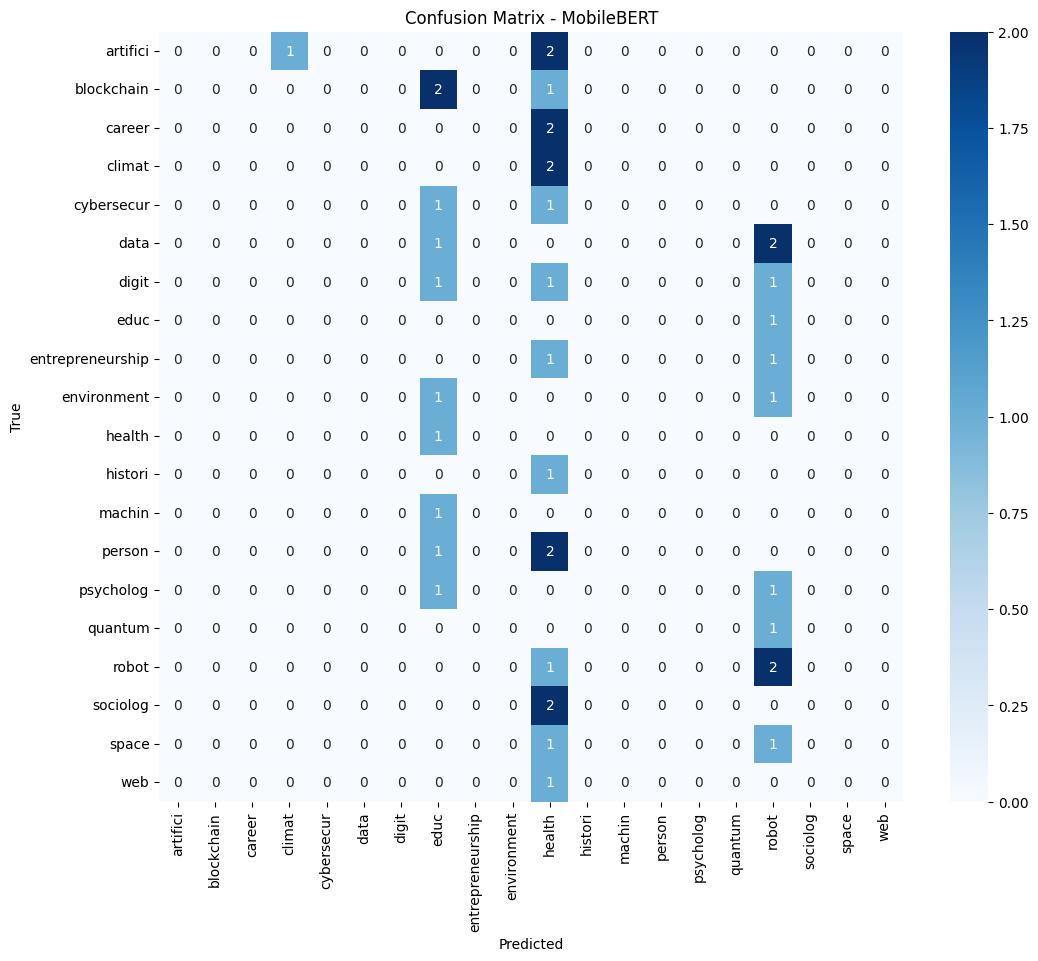

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12,10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - MobileBERT')
plt.show()

In [59]:
        # Identify best model - Tried to get it
df_results = pd.DataFrame(results)
best_row = df_results.loc[df_results['accuracy'].idxmax()]
print("Best model based on accuracy:\n", best_row)

Best model based on accuracy:
 model                DistilBERT
accuracy                   0.05
f1_weighted            0.021429
f1_macro               0.014286
precision              0.013636
recall                     0.05
inference_time_ms    280.195421
Name: 0, dtype: object
